In [1]:
import requests
import pandas as pd

url = 'https://data.wprdc.org/api/3/action/datastore_search'
params = {
    'resource_id': '29462525-62a6-45bf-9b5e-ad2e1c06348d',
    'limit': 10000  # adjust this as needed
}
response = requests.get(url, params=params)
records = response.json()['result']['records']


df = pd.DataFrame(records)


df_filtered = df[(df['latitude'].notnull()) & (df['longitude'].notnull())]

df_filtered.to_csv('filtered_311.csv', index=False)

print(f"Saved {len(df_filtered)} records with coordinates.")


Saved 8222 records with coordinates.


In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [10]:
df_311 = pd.read_csv('filtered_311.csv')

df_311 = df_311[(df_311['latitude'] != 0.000000) & (df_311['longitude'] != 0.000000)]
df_311 = df_311.dropna(subset=['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(df_311['longitude'], df_311['latitude'])]
gdf_311 = gpd.GeoDataFrame(df_311, geometry=geometry, crs="EPSG:4326")
gdf_311 = gdf_311.to_crs("EPSG:3857")


In [11]:
print("Number of valid 311 records:", len(df_311))
print(df_311[['latitude', 'longitude']].head(10))

Number of valid 311 records: 8141
     latitude  longitude
2   40.443452 -80.004199
6   40.405903 -79.911995
7   40.479870 -79.916472
11  40.448091 -79.996128
18  40.479870 -79.916472
22  40.439236 -80.010609
23  40.482654 -79.916638
24  40.446735 -79.999769
29  40.446432 -79.999620
33  40.448080 -80.040519


In [14]:
print("Original shapefile CRS:", gpd.read_file('/Users/mkay11/Catnip-final-project-1/Neighborhood boundaries/neighborhoods (1)/Neighborhoods_.shp').crs)


Original shapefile CRS: EPSG:2272


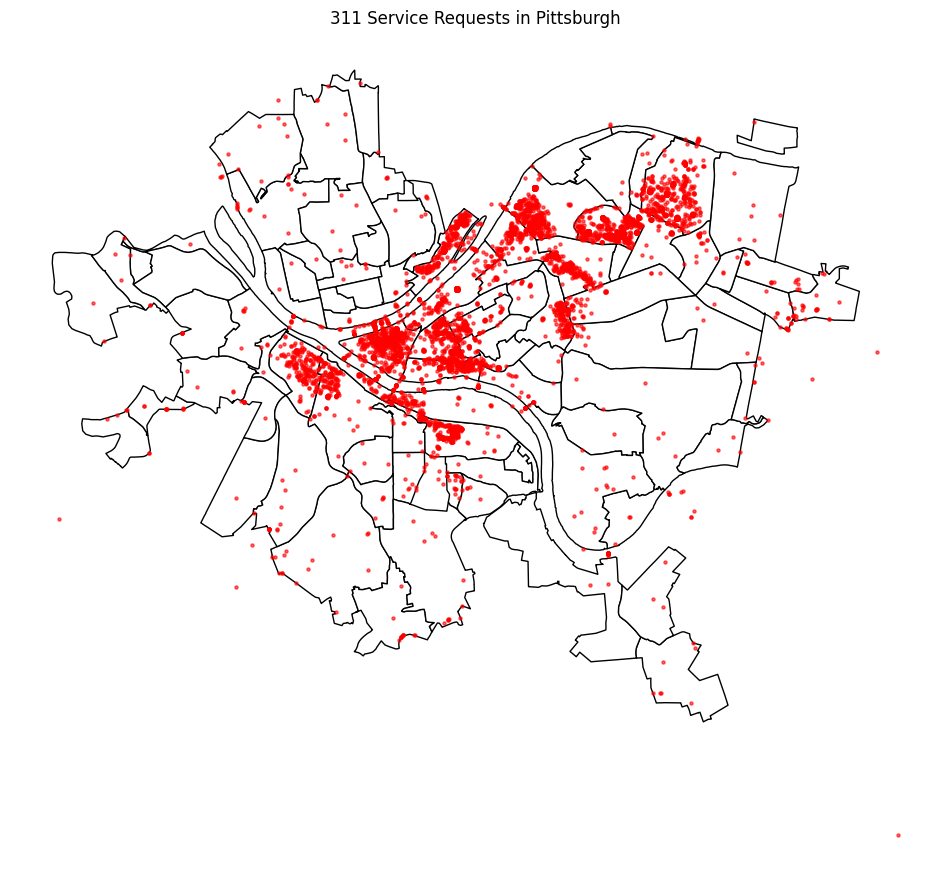

In [16]:
pgh_shp = gpd.read_file('/Users/mkay11/Catnip-final-project-1/Neighborhood boundaries/neighborhoods (1)/Neighborhoods_.shp')

df_311 = pd.read_csv('filtered_311.csv')
df_311 = df_311[(df_311['latitude'] != 0) & (df_311['longitude'] != 0)]
df_311 = df_311.dropna(subset=['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(df_311['longitude'], df_311['latitude'])]
gdf_311 = gpd.GeoDataFrame(df_311, geometry=geometry, crs="EPSG:4326")
gdf_311 = gdf_311.to_crs("EPSG:2272")

fig, ax = plt.subplots(figsize=(12, 12))
pgh_shp.plot(ax=ax, color='white', edgecolor='black')
gdf_311.plot(ax=ax, markersize=5, color='red', alpha=0.6)
plt.title("311 Service Requests in Pittsburgh")
plt.axis('off')
plt.show()


In [19]:


gdf_joined = gpd.sjoin(gdf_311, pgh_shp, how='left', predicate='within')


counts = gdf_joined.groupby('hood').size().reset_index(name='request_count')


counts.to_csv('311_counts_by_neighborhood.csv', index=False)
counts_sorted = counts.sort_values(by='request_count', ascending=True)
print(counts_sorted.head(10))


                    hood  request_count
43            Manchester              1
31            Greenfield              1
2             Banksville              1
28              Fineview              1
11  California-Kirkbride              1
58    Point Breeze North              1
60         Regent Square              2
17               Chateau              2
32                  Hays              2
74           Summer Hill              2
